In [57]:
import pandas as pd
import numpy as np
import optuna
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import shap

In [2]:
df = pd.read_csv('Final_df.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8902 entries, 8526.0 to 3135.0
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   atm_group                8902 non-null   float64
 1   address                  8902 non-null   object 
 2   address_rus              8482 non-null   object 
 3   lat                      8482 non-null   float64
 4   long                     8482 non-null   float64
 5   target                   6358 non-null   float64
 6   isTrain                  8902 non-null   bool   
 7   geometry                 8902 non-null   object 
 8   buffer                   8902 non-null   object 
 9   poi_count                8902 non-null   int64  
 10  poi_amenities            7814 non-null   object 
 11  marketplace_flag         8902 non-null   int64  
 12  fuel_flag                8902 non-null   int64  
 13  charging_station_flag    8902 non-null   int64  
 14  drinking_water_flag   

В качестве базовой метрики для сравнения возьмем среднее значение таргета

In [4]:
df = df[df['isTrain'] == True]

Y = df['target']
X = df.drop(columns=['target', 'isTrain','address','address_rus','geometry','buffer'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [5]:
baseline_value = y_train.mean()
y_pred_manual = np.full_like(y_test, baseline_value, dtype=np.float64)

mse_manual = mean_squared_error(y_test, y_pred_manual)
rmse_manual = np.sqrt(mse_manual)
r2_manual = r2_score(y_test, y_pred_manual)

print("\nManual Baseline (Mean) Performance:")
print("MSE:", mse_manual)
print("RMSE:", rmse_manual)
print("R^2:", r2_manual)


Manual Baseline (Mean) Performance:
MSE: 0.0075916820236393585
RMSE: 0.08713025894394759
R^2: -5.193246293000442e-07


Линейная регрессия

In [28]:
df_train = df[df['isTrain'] == True]

Y = df_train['target']
X = df_train.drop(columns=['target', 'isTrain', 'address', 'address_rus', 'geometry', 'buffer', 'poi_amenities', 'city'])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

linreg = LinearRegression()
linreg.fit(X_train_imputed, y_train)

y_pred_lin = linreg.predict(X_test_imputed)

mse_lin = mean_squared_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("Линейная регрессия:")
print("MSE:", mse_lin)
print("RMSE:", rmse_lin)
print("R^2:", r2_lin)



Линейная регрессия:
MSE: 0.005208636414630403
RMSE: 0.0721708834269777
R^2: 0.31390183316626574


Прогресс есть, идем дальше, воспользуемся стандартным масштабированием

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_pred = linreg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Линейная регрессия со стандартным масштабированием:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

Линейная регрессия со стандартным масштабированием:
MSE: 5.04327227783562e+18
RMSE: 2245723108.0067773
R^2: -6.643158764061938e+20


Стало хуже, попробуем DecisionTreeRegressor

Lasso

In [22]:
lasso = Lasso(alpha=1.0, random_state=42)  # можно настроить alpha
lasso.fit(X_train_scaled, y_train)

# Предсказываем значения на тестовой выборке
y_pred = lasso.predict(X_test_scaled)

# Вычисляем метрики
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Lasso Regression:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

Lasso Regression:
MSE: 0.0075916820236393585
RMSE: 0.08713025894394759
R^2: -5.193246293000442e-07


Подберем гиперпараметры

In [27]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

lasso = Lasso(random_state=42, max_iter=10000)

grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Лучшее значение alpha:", grid_search.best_params_['alpha'])
print("Лучший кросс-валидационный score (отрицательная MSE):", grid_search.best_score_)

best_lasso = grid_search.best_estimator_

y_pred = best_lasso.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nРезультаты на тестовой выборке для лучшей модели Lasso:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

Лучшее значение alpha: 0.001
Лучший кросс-валидационный score (отрицательная MSE): -0.005072664671816076

Результаты на тестовой выборке для лучшей модели Lasso:
MSE: 0.005206325419086802
RMSE: 0.07215487106971227
R^2: 0.31420624485481663


Ridge

In [33]:
ridge = Ridge(random_state=42)

grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Лучшее значение alpha:", grid_search.best_params_['alpha'])
print("Лучший кросс-валидационный score (отрицательная MSE):", grid_search.best_score_)

best_ridge = grid_search.best_estimator_

y_pred_ridge = best_ridge.predict(X_test_scaled)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\nРезультаты на тестовой выборке для лучшей модели Ridge:")
print("MSE:", mse_ridge)
print("RMSE:", rmse_ridge)
print("R^2:", r2_ridge)

Лучшее значение alpha: 100.0
Лучший кросс-валидационный score (отрицательная MSE): -0.005096952530678582

Результаты на тестовой выборке для лучшей модели Ridge:
MSE: 0.005210827797467809
RMSE: 0.07218606373440659
R^2: 0.3136131772440838


ElasticNet

In [47]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

elastic_net = ElasticNet(random_state=42, max_iter=10000)

grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший кросс-валидационный score (отрицательная MSE):", grid_search.best_score_)

best_elastic = grid_search.best_estimator_

y_pred_en = best_elastic.predict(X_test_scaled)

mse_en = mean_squared_error(y_test, y_pred_en)
rmse_en = np.sqrt(mse_en)
r2_en = r2_score(y_test, y_pred_en)

print("\nРезультаты на тестовой выборке для лучшей модели ElasticNet:")
print("MSE:", mse_en)
print("RMSE:", rmse_en)
print("R^2:", r2_en)

Лучшие параметры: {'alpha': 0.001, 'l1_ratio': 0.9}
Лучший кросс-валидационный score (отрицательная MSE): -0.005073147538332543

Результаты на тестовой выборке для лучшей модели ElasticNet:
MSE: 0.005206282368497156
RMSE: 0.07215457274835155
R^2: 0.3142119156155083


OHE

In [50]:
df_train = df[df['isTrain'] == True]

Y = df_train['target']
X = df_train.drop(columns=['target', 'isTrain', 'address', 'address_rus', 'geometry', 'buffer', 'poi_amenities'])

categorical_features = ['city', 'atm_group']
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

elastic_net = ElasticNet(random_state=42, max_iter=10000)

grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший кросс-валидационный score (отрицательная MSE):", grid_search.best_score_)

best_en = grid_search.best_estimator_
y_pred = best_en.predict(X_test_scaled)

mse_en = mean_squared_error(y_test, y_pred)
rmse_en = np.sqrt(mse_en)
r2_en = r2_score(y_test, y_pred)

print("\nРезультаты на тестовой выборке для ElasticNet с OHE:")
print("MSE:", mse_en)
print("RMSE:", rmse_en)
print("R^2:", r2_en)


Лучшие параметры: {'alpha': 0.001, 'l1_ratio': 0.7}
Лучший кросс-валидационный score (отрицательная MSE): -0.0021918302106326364

Результаты на тестовой выборке для ElasticNet с OHE:
MSE: 0.002274398708631506
RMSE: 0.047690656408058654
R^2: 0.7004089630334052


DecisionTreeRegressor

In [49]:
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train_imputed, y_train)

y_pred_tree = tree.predict(X_test_imputed)


mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("Decision Tree Regressor Performance:")
print("MSE:", mse_tree)
print("RMSE:", rmse_tree)
print("R^2:", r2_tree)

Decision Tree Regressor Performance:
MSE: 0.003533970363629737
RMSE: 0.05944720652503141
R^2: 0.5344941756117647


In [39]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_imputed, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший кросс-валидационный score (отрицательная MSE):", grid_search.best_score_)

best_rf = grid_search.best_estimator_

y_pred_rf = best_rf.predict(X_test_imputed)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nРезультаты на тестовой выборке для лучшей модели RandomForestRegressor:")
print("MSE:", mse_rf)
print("RMSE:", rmse_rf)
print("R^2:", r2_rf)

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
157 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.11/site-packag

Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Лучший кросс-валидационный score (отрицательная MSE): -0.0020892168282480527

Результаты на тестовой выборке для лучшей модели RandomForestRegressor:
MSE: 0.0021308960016955965
RMSE: 0.046161629105736686
R^2: 0.7193115963383241


CatBoostRegressor

In [51]:
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 200, 500]
}

cat_model = CatBoostRegressor(loss_function='RMSE', random_seed=42, verbose=0)

grid_search = GridSearchCV(cat_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_imputed, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший кросс-валидационный score (отрицательная MSE):", grid_search.best_score_)

best_cat = grid_search.best_estimator_

y_pred_cat = best_cat.predict(X_test_imputed)

mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print("\nРезультаты на тестовой выборке для лучшей модели CatBoostRegressor:")
print("MSE:", mse_cat)
print("RMSE:", rmse_cat)
print("R^2:", r2_cat)

Лучшие параметры: {'depth': 8, 'iterations': 200, 'learning_rate': 0.2}
Лучший кросс-валидационный score (отрицательная MSE): -0.0020230928257406714

Результаты на тестовой выборке для лучшей модели CatBoostRegressor:
MSE: 0.002058849034883391
RMSE: 0.0453745417043896
R^2: 0.7288018521213806


In [44]:
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 5, 10]
}

lgbm = LGBMRegressor(random_state=42)

grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_imputed, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший кросс-валидационный score (отрицательная MSE):", grid_search.best_score_)

best_lgbm = grid_search.best_estimator_

y_pred_lgbm = best_lgbm.predict(X_test_imputed)

mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("\nРезультаты на тестовой выборке для лучшей модели LGBMRegressor:")
print("MSE:", mse_lgbm)
print("RMSE:", rmse_lgbm)
print("R^2:", r2_lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number of data points in the train set: 3560, number of used features: 13
[LightGBM] [Info] Start training from score 0.000157
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1041
[LightGBM] [Info] Number of data points in the train set: 3560, number of used features: 13
[LightGBM] [Info] Start training from score 0.000501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

GradientBoostingRegressor

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

gbr = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_imputed, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший кросс-валидационный score (отрицательная MSE):", grid_search.best_score_)

best_gbr = grid_search.best_estimator_

y_pred_gbr = best_gbr.predict(X_test_imputed)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("\nРезультаты на тестовой выборке для лучшей модели GradientBoostingRegressor:")
print("MSE:", mse_gbr)
print("RMSE:", rmse_gbr)
print("R^2:", r2_gbr)

XGBRegressor

In [55]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший кросс-валидационный score (отрицательная MSE):", grid_search.best_score_)

best_xgb = grid_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nРезультаты на тестовой выборке для лучшей модели XGBRegressor:")
print("MSE:", mse_xgb)
print("RMSE:", rmse_xgb)
print("R^2:", r2_xgb)

Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
Лучший кросс-валидационный score (отрицательная MSE): -0.0020230114822195368

Результаты на тестовой выборке для лучшей модели XGBRegressor:
MSE: 0.0020574162928616306
RMSE: 0.04535875100641144
R^2: 0.7289905774606872


Лучшая линейная ElasticNet с OHE
Лучшая в абсолюте XGBRegressor

Топ 10 признаков для модели ElasticNet с OHE:
atm_group_8083.0    0.066339
atm_group_1942.0    0.013223
atm_group_1022.0    0.007171
city_Москва         0.006819
long                0.005931
bank_flag           0.005326
atm_group_496.5     0.004191
atm_group_3185.5    0.003117
city_Норильск       0.002899
city_Якутск         0.002350
dtype: float64


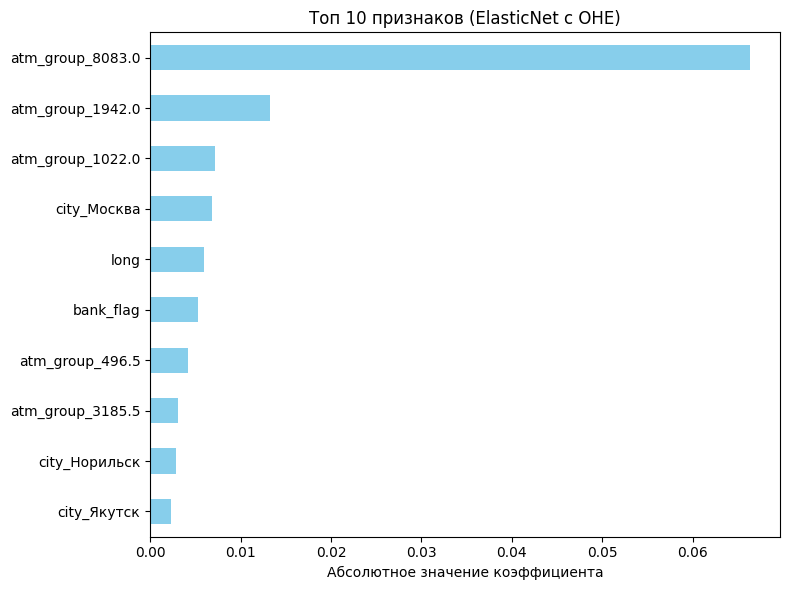


Топ 10 признаков для модели XGBRegressor:
atm_group_8083.0               0.399034
atm_group_1942.0               0.042367
atm_group_1022.0               0.031495
atm_group_3185.5               0.027227
atm_group_5478.0               0.023536
atm_group_496.5                0.015492
city_Москва                    0.006245
city_рабочий посёлок Охотск    0.004190
city_Казань                    0.003826
city_Самара                    0.003223
dtype: float32


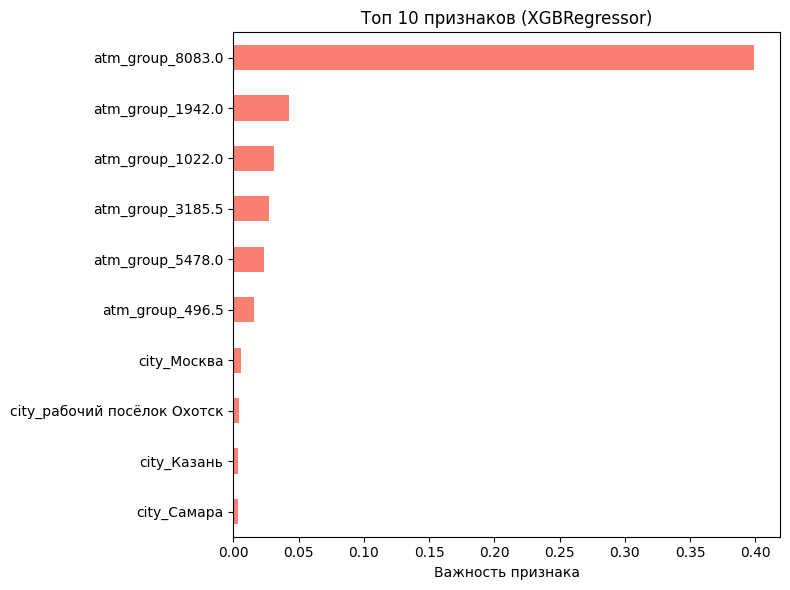

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

en_coef = pd.Series(np.abs(best_en.coef_), index=X_train.columns)
top_features_en = en_coef.sort_values(ascending=False).head(10)
print("Топ 10 признаков для модели ElasticNet с OHE:")
print(top_features_en)

plt.figure(figsize=(8, 6))
top_features_en.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel("Абсолютное значение коэффициента")
plt.title("Топ 10 признаков (ElasticNet с OHE)")
plt.tight_layout()
plt.show()

xgb_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
top_features_xgb = xgb_importances.sort_values(ascending=False).head(10)
print("\nТоп 10 признаков для модели XGBRegressor:")
print(top_features_xgb)

plt.figure(figsize=(8, 6))
top_features_xgb.sort_values().plot(kind='barh', color='salmon')
plt.xlabel("Важность признака")
plt.title("Топ 10 признаков (XGBRegressor)")
plt.tight_layout()
plt.show()


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


SHAP summary для ElasticNet:


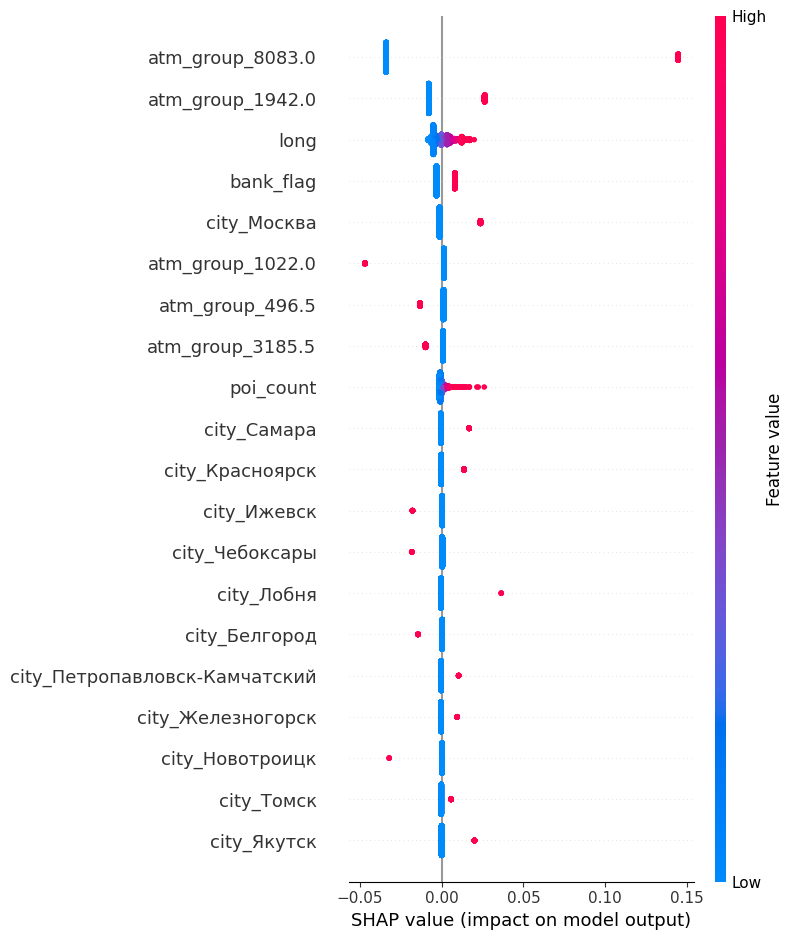

[00:01:28] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


SHAP summary для XGBRegressor:


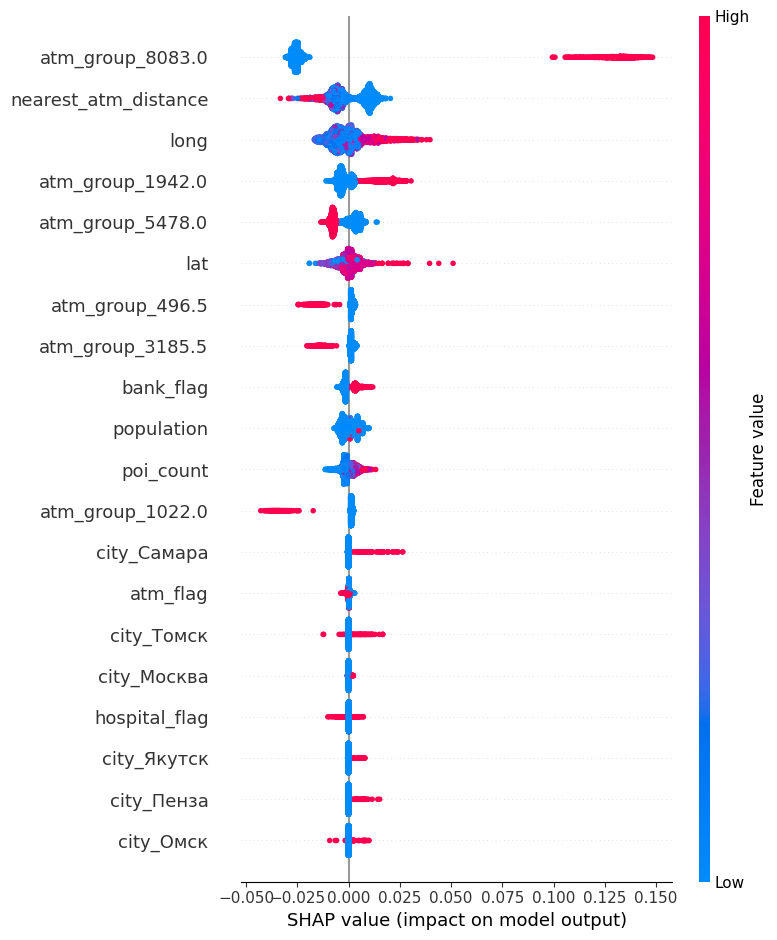

In [60]:
shap.initjs()

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

explainer_en = shap.LinearExplainer(best_en, X_train_scaled_df, feature_dependence="independent")
shap_values_en = explainer_en.shap_values(X_train_scaled_df)

print("SHAP summary для ElasticNet:")
shap.summary_plot(shap_values_en, X_train_scaled_df)


explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_train_scaled_df)

print("SHAP summary для XGBRegressor:")
shap.summary_plot(shap_values_xgb, X_train_scaled_df)

In [63]:
df_train = df[df['isTrain'] == True]

Y = df_train['target']

X = df_train.drop(columns=['target', 'isTrain', 'address', 'address_rus', 'geometry', 'buffer', 'poi_amenities', 'atm_group'])

if 'city' in X.columns:
    X = pd.get_dummies(X, columns=['city'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

elastic_net = ElasticNet(random_state=42, max_iter=10000)
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший кросс-валидационный score (отрицательная MSE):", grid_search.best_score_)

best_en = grid_search.best_estimator_
y_pred = best_en.predict(X_test_scaled)

mse_en = mean_squared_error(y_test, y_pred)
rmse_en = np.sqrt(mse_en)
r2_en = r2_score(y_test, y_pred)

print("\nРезультаты на тестовой выборке для ElasticNet с OHE (без atm_group):")
print("MSE:", mse_en)
print("RMSE:", rmse_en)
print("R^2:", r2_en)


Лучшие параметры: {'alpha': 0.01, 'l1_ratio': 0.1}
Лучший кросс-валидационный score (отрицательная MSE): -0.006514130842351746

Результаты на тестовой выборке для ElasticNet с OHE (без atm_group):
MSE: 0.006551221517981491
RMSE: 0.08093961649267614
R^2: 0.13705225010838884


In [62]:
df_train = df[df['isTrain'] == True]

Y = df_train['target']
X = df_train.drop(columns=['target', 'isTrain', 'address', 'address_rus', 'geometry', 'buffer', 'poi_amenities', 'atm_group'])

if 'city' in X.columns:
    X = pd.get_dummies(X, columns=['city'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший кросс-валидационный score (отрицательная MSE):", grid_search.best_score_)

best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nРезультаты на тестовой выборке для лучшей модели XGBRegressor:")
print("MSE:", mse_xgb)
print("RMSE:", rmse_xgb)
print("R^2:", r2_xgb)


Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
Лучший кросс-валидационный score (отрицательная MSE): -0.006194688240273455

Результаты на тестовой выборке для лучшей модели XGBRegressor:
MSE: 0.006119594558777234
RMSE: 0.07822783749265497
R^2: 0.1939075269778291


Топ 10 признаков для модели ElasticNet с OHE:
long                                      0.011885
population                                0.008487
city_Норильск                             0.007695
city_Кызыл                                0.007461
city_Москва                               0.006199
city_Абакан                               0.004954
city_Дубна                                0.004718
city_Элиста                               0.004601
city_Санкт-Петербург                      0.004203
city_посёлок городского типа Лучегорск    0.004148
dtype: float64


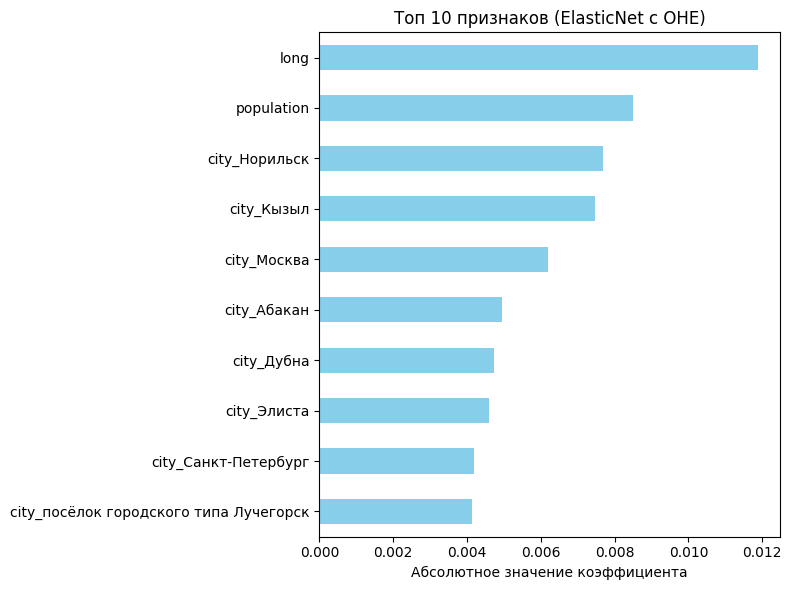


Топ 10 признаков для модели XGBRegressor:
city_Москва                      0.031246
city_Норильск                    0.014823
city_Кызыл                       0.009937
city_Тюмень                      0.008017
population                       0.007202
city_Абакан                      0.007130
city_Петропавловск-Камчатский    0.006815
city_Самара                      0.006538
city_Элиста                      0.006511
city_Санкт-Петербург             0.006488
dtype: float32


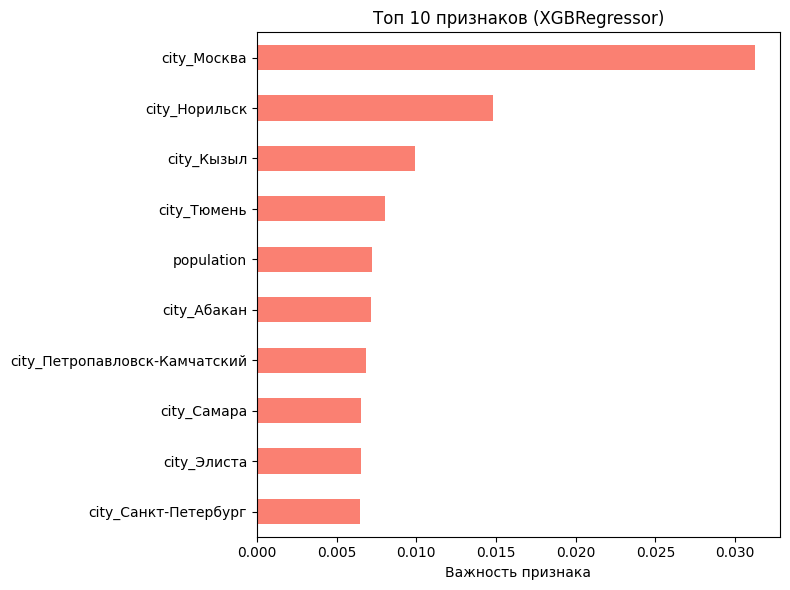

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

en_coef = pd.Series(np.abs(best_en.coef_), index=X_train.columns)
top_features_en = en_coef.sort_values(ascending=False).head(10)
print("Топ 10 признаков для модели ElasticNet с OHE:")
print(top_features_en)

plt.figure(figsize=(8, 6))
top_features_en.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel("Абсолютное значение коэффициента")
plt.title("Топ 10 признаков (ElasticNet с OHE)")
plt.tight_layout()
plt.show()

xgb_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
top_features_xgb = xgb_importances.sort_values(ascending=False).head(10)
print("\nТоп 10 признаков для модели XGBRegressor:")
print(top_features_xgb)

plt.figure(figsize=(8, 6))
top_features_xgb.sort_values().plot(kind='barh', color='salmon')
plt.xlabel("Важность признака")
plt.title("Топ 10 признаков (XGBRegressor)")
plt.tight_layout()
plt.show()
